NOTEBOOK 02: ANÁLISIS EXPLORATORIO DE DATOS ENTOMOLÓGICOS

TFM: Detección de Brotes de Dengue usando IA - Cauca, Colombia

Autor: Diego Alejandro González Acuña

Fecha: 2025

Este notebook realiza el análisis exploratorio exhaustivo de los datos
entomológicos (entomologico_clean.csv) correspondientes a capturas de
vectores durante 9 meses de 2021 en los municipios del Cauca.

Objetivos:
1. Caracterizar la diversidad taxonómica de vectores
2. Analizar abundancia y densidad vectorial
3. Identificar distribución espacial de especies
4. Evaluar concordancia con casos humanos
5. Generar visualizaciones para el Capítulo 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from datetime import datetime
from scipy import stats
from scipy.interpolate import griddata
import warnings

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [ ]:
# ============================================================================
# 2. CARGA DE DATOS
# ============================================================================

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Dataset_Denque/entomologico_clean.csv'

df_vectores = pd.read_csv(DATA_PATH)

print(f"\n{'='*80}")
print(f"DATASET CARGADO: entomologico_clean.csv")
print(f"{'='*80}")
print(f"Filas (capturas): {df_vectores.shape[0]:,}")
print(f"Columnas: {df_vectores.shape[1]}")
print(f"\nPrimeras 5 filas:")
print(df_vectores.head())


DATASET CARGADO: entomologico_clean.csv
Filas (capturas): 529
Columnas: 18

Primeras 5 filas:
                                 id  individualCount                   sex  \
0   INS:ProyectoDengue67217:Aed-001                5  2 Machos | 3 Hembras   
1   INS:ProyectoDengue67217:Aed-002                1                Hembra   
2   INS:ProyectoDengue67217:Aed-003                2    1 Macho | 1 Hembra   
3  INS:ProyectoDengue67217:Culx-001                6  3 Machos | 3 Hembras   
4  INS:ProyectoDengue67217:Culx-002                2             2 Hembras   

          organismRemarks              eventID   eventDate locationID county  \
0  Sin alimento de sangre  Barrio_Puerto_Nuevo  2021-02-10   CO:19532  Patía   
1  Sin alimento de sangre  Barrio_Puerto_Nuevo  2021-02-10   CO:19532  Patía   
2       Hembra con sangre  Barrio_Puerto_Nuevo  2021-02-10   CO:19532  Patía   
3     1 hembra con sangre  Barrio_Puerto_Nuevo  2021-02-10   CO:19532  Patía   
4     1 hembra con sangre  Barrio_Pu

In [ ]:
# ============================================================================
# 3. EXPLORACIÓN INICIAL
# ============================================================================

print(f"\n{'='*80}")
print("INFORMACIÓN DEL DATASET")
print(f"{'='*80}")
print(df_vectores.info())

print(f"\n{'='*80}")
print("ESTADÍSTICAS DESCRIPTIVAS")
print(f"{'='*80}")
print(df_vectores.describe())

# Verificar valores faltantes
print(f"\n{'='*80}")
print("VALORES FALTANTES")
print(f"{'='*80}")
missing = df_vectores.isnull().sum()
missing_pct = (missing / len(df_vectores)) * 100
missing_df = pd.DataFrame({
    'Columna': missing.index,
    'Valores Faltantes': missing.values,
    'Porcentaje (%)': missing_pct.values
})
print(missing_df[missing_df['Valores Faltantes'] > 0])


INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    529 non-null    object 
 1   individualCount       529 non-null    int64  
 2   sex                   529 non-null    object 
 3   organismRemarks       38 non-null     object 
 4   eventID               529 non-null    object 
 5   eventDate             529 non-null    object 
 6   locationID            529 non-null    object 
 7   county                529 non-null    object 
 8   locality              529 non-null    object 
 9   verbatimElevation     529 non-null    object 
 10  decimalLatitude       529 non-null    float64
 11  decimalLongitude      529 non-null    float64
 12  scientificName        529 non-null    object 
 13  higherClassification  529 non-null    object 
 14  genus                 529 non-null    object 
 15

In [ ]:
# ============================================================================
# 4. PREPROCESAMIENTO DE FECHAS
# ============================================================================

print(f"\n{'='*80}")
print("PREPROCESAMIENTO DE FECHAS")
print(f"{'='*80}")

df_vectores['eventDate'] = pd.to_datetime(df_vectores['eventDate'])
df_vectores['año'] = df_vectores['eventDate'].dt.year
df_vectores['mes'] = df_vectores['eventDate'].dt.month
df_vectores['mes_nombre'] = df_vectores['eventDate'].dt.month_name()
df_vectores['semana'] = df_vectores['eventDate'].dt.isocalendar().week

print(f"Rango temporal: {df_vectores['eventDate'].min().date()} a {df_vectores['eventDate'].max().date()}")
print(f"Duración: {(df_vectores['eventDate'].max() - df_vectores['eventDate'].min()).days} días")
print(f"Meses únicos: {df_vectores['mes'].nunique()}")


PREPROCESAMIENTO DE FECHAS
Rango temporal: 2021-02-10 a 2021-11-11
Duración: 274 días
Meses únicos: 6



ANÁLISIS DE DIVERSIDAD TAXONÓMICA

Tabla 4.5: Especies de Mosquitos Identificadas
               Especie  Num_Capturas  Total_Individuos  Pct_Capturas  Pct_Individuos
Culex quinquefasciatus           278              1775          52.6            74.5
         Aedes aegypti           232               572          43.9            24.0
      Aedes albopictus            19                36           3.6             1.5

📊 AEDES AEGYPTI (Vector principal del dengue):
   • Capturas: 232 (43.9%)
   • Individuos: 572 (24.0%)
   • Media individuos/captura: 2.5


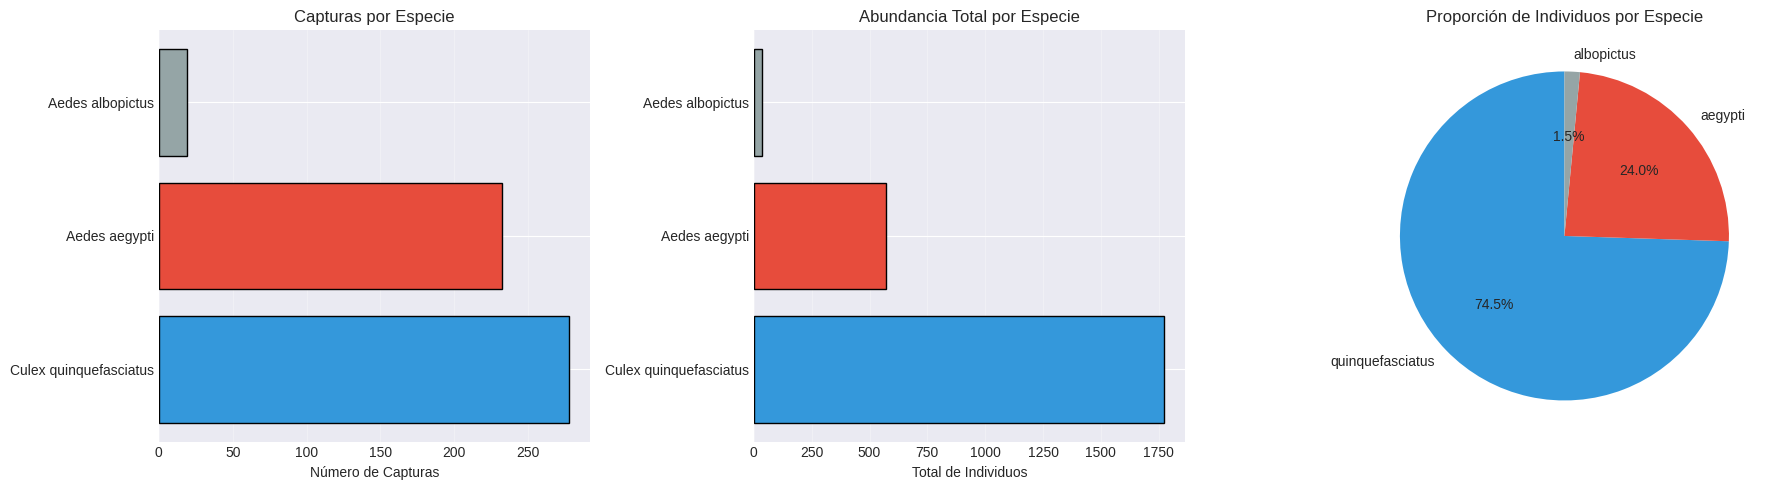

In [ ]:
# ============================================================================
# 5. ANÁLISIS DE DIVERSIDAD TAXONÓMICA
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE DIVERSIDAD TAXONÓMICA")
print(f"{'='*80}")

# Especies identificadas
especies = df_vectores.groupby('scientificName').agg({
    'id': 'count',
    'individualCount': 'sum'
}).reset_index()
especies.columns = ['Especie', 'Num_Capturas', 'Total_Individuos']
especies['Pct_Capturas'] = (especies['Num_Capturas'] / especies['Num_Capturas'].sum() * 100).round(1)
especies['Pct_Individuos'] = (especies['Total_Individuos'] / especies['Total_Individuos'].sum() * 100).round(1)
especies = especies.sort_values('Total_Individuos', ascending=False)

print("\nTabla 4.5: Especies de Mosquitos Identificadas")
print(especies.to_string(index=False))

# Enfoque en Aedes aegypti (vector principal)
aedes_aegypti = df_vectores[df_vectores['scientificName'] == 'Aedes aegypti']
print(f"\n📊 AEDES AEGYPTI (Vector principal del dengue):")
print(f"   • Capturas: {len(aedes_aegypti)} ({len(aedes_aegypti)/len(df_vectores)*100:.1f}%)")
print(f"   • Individuos: {aedes_aegypti['individualCount'].sum()} ({aedes_aegypti['individualCount'].sum()/df_vectores['individualCount'].sum()*100:.1f}%)")
print(f"   • Media individuos/captura: {aedes_aegypti['individualCount'].mean():.1f}")

# Visualización: Composición de especies
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Número de capturas
colors = ['#e74c3c' if 'aegypti' in sp else '#3498db' if 'Culex' in sp else '#95a5a6'
          for sp in especies['Especie']]
axes[0].barh(especies['Especie'], especies['Num_Capturas'], color=colors, edgecolor='black')
axes[0].set_xlabel('Número de Capturas')
axes[0].set_title('Capturas por Especie')
axes[0].grid(axis='x', alpha=0.3)

# Gráfico 2: Total de individuos
axes[1].barh(especies['Especie'], especies['Total_Individuos'], color=colors, edgecolor='black')
axes[1].set_xlabel('Total de Individuos')
axes[1].set_title('Abundancia Total por Especie')
axes[1].grid(axis='x', alpha=0.3)

# Gráfico 3: Pie chart de individuos
axes[2].pie(especies['Total_Individuos'], labels=[sp.split()[-1] for sp in especies['Especie']],
           autopct='%1.1f%%', startangle=90, colors=colors)
axes[2].set_title('Proporción de Individuos por Especie')

plt.tight_layout()
plt.savefig('fig_4_8_diversidad_especies.png', dpi=300, bbox_inches='tight')
plt.show()



ANÁLISIS DE COMPOSICIÓN SEXUAL - Aedes aegypti

Composición Sexual de Aedes aegypti:
   • Machos: 273 (4.2%)
   • Hembras: 6158 (95.8%)
   • Ratio Hembra:Macho = 22.56:1

⚠️  RELEVANCIA EPIDEMIOLÓGICA: Solo hembras transmiten dengue


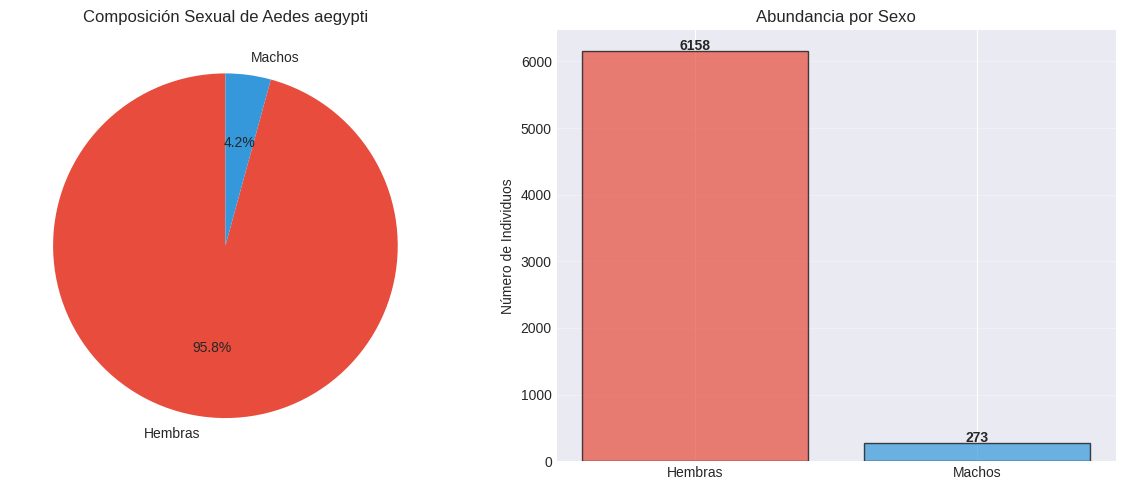

In [ ]:
# ============================================================================
# 6. ANÁLISIS DE COMPOSICIÓN SEXUAL (Aedes aegypti)
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE COMPOSICIÓN SEXUAL - Aedes aegypti")
print(f"{'='*80}")

# Extraer información de sexo de la columna 'sex'
def parse_sex(sex_str):
    """Parsear la columna sex para extraer machos y hembras"""
    if pd.isna(sex_str):
        return 0, 0

    sex_str = str(sex_str).lower()
    machos = 0
    hembras = 0

    if 'macho' in sex_str:
        try:
            num = int(''.join(filter(str.isdigit, sex_str.split('macho')[0])))
            machos = num if num > 0 else 1
        except:
            machos = 1

    if 'hembra' in sex_str:
        try:
            num = int(''.join(filter(str.isdigit, sex_str.split('hembra')[0])))
            hembras = num if num > 0 else 1
        except:
            hembras = 1

    return machos, hembras

# Aplicar parsing solo a Aedes aegypti
aedes_sex = aedes_aegypti.copy()
aedes_sex[['machos', 'hembras']] = aedes_sex['sex'].apply(lambda x: pd.Series(parse_sex(x)))

total_machos = aedes_sex['machos'].sum()
total_hembras = aedes_sex['hembras'].sum()
total_sexo = total_machos + total_hembras

print(f"\nComposición Sexual de Aedes aegypti:")
print(f"   • Machos: {total_machos} ({total_machos/total_sexo*100:.1f}%)")
print(f"   • Hembras: {total_hembras} ({total_hembras/total_sexo*100:.1f}%)")
print(f"   • Ratio Hembra:Macho = {total_hembras/total_machos:.2f}:1")
print(f"\n⚠️  RELEVANCIA EPIDEMIOLÓGICA: Solo hembras transmiten dengue")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
axes[0].pie([total_hembras, total_machos], labels=['Hembras', 'Machos'],
           autopct='%1.1f%%', startangle=90, colors=['#e74c3c', '#3498db'])
axes[0].set_title('Composición Sexual de Aedes aegypti')

# Bar chart
sexo_data = pd.DataFrame({
    'Sexo': ['Hembras', 'Machos'],
    'Individuos': [total_hembras, total_machos]
})
axes[1].bar(sexo_data['Sexo'], sexo_data['Individuos'],
           color=['#e74c3c', '#3498db'], edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Número de Individuos')
axes[1].set_title('Abundancia por Sexo')
axes[1].grid(axis='y', alpha=0.3)
for i, row in sexo_data.iterrows():
    axes[1].text(i, row['Individuos'] + 20, str(row['Individuos']),
                ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('fig_4_9_composicion_sexual.png', dpi=300, bbox_inches='tight')
plt.show()



ANÁLISIS DE ABUNDANCIA Y DENSIDAD VECTORIAL

Tabla 4.6: Estadísticas de Abundancia por Especie
                        count  mean  median  std  min  max  p25  p75
scientificName                                                      
Aedes aegypti             232   2.5     1.0  4.7    1   60  1.0  2.0
Aedes albopictus           19   1.9     1.0  2.1    1    9  1.0  2.0
Culex quinquefasciatus    278   6.4     2.0  9.9    1   90  1.0  7.0


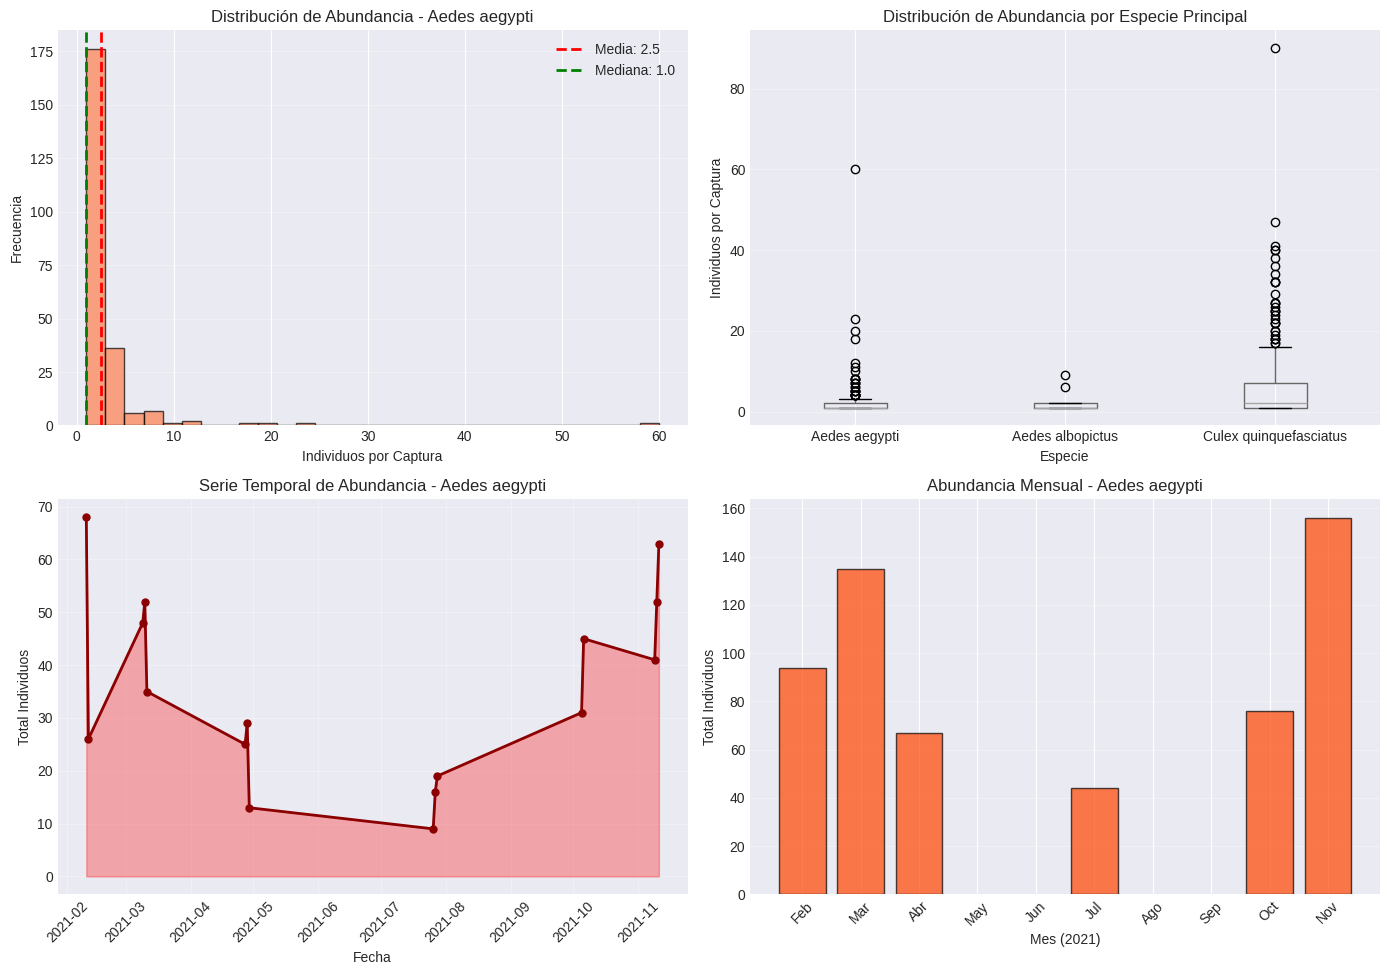


📈 PATRÓN TEMPORAL:
   • Pico de abundancia: November
   • Mínimo: July


In [ ]:
# ============================================================================
# 7. ANÁLISIS DE ABUNDANCIA Y DENSIDAD
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE ABUNDANCIA Y DENSIDAD VECTORIAL")
print(f"{'='*80}")

# Estadísticas de abundancia
abundancia_stats = df_vectores.groupby('scientificName')['individualCount'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    ('p25', lambda x: x.quantile(0.25)),
    ('p75', lambda x: x.quantile(0.75))
]).round(1)

print("\nTabla 4.6: Estadísticas de Abundancia por Especie")
print(abundancia_stats)

# Visualización: Distribución de abundancia (Aedes aegypti)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histograma
axes[0, 0].hist(aedes_aegypti['individualCount'], bins=30,
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Individuos por Captura')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Abundancia - Aedes aegypti')
axes[0, 0].axvline(aedes_aegypti['individualCount'].mean(), color='red',
                  linestyle='--', label=f'Media: {aedes_aegypti["individualCount"].mean():.1f}', linewidth=2)
axes[0, 0].axvline(aedes_aegypti['individualCount'].median(), color='green',
                  linestyle='--', label=f'Mediana: {aedes_aegypti["individualCount"].median():.1f}', linewidth=2)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Boxplot por especie
especies_principales = df_vectores[df_vectores['scientificName'].isin(
    especies.head(3)['Especie'])]
especies_principales.boxplot(column='individualCount', by='scientificName', ax=axes[0, 1])
axes[0, 1].set_xlabel('Especie')
axes[0, 1].set_ylabel('Individuos por Captura')
axes[0, 1].set_title('Distribución de Abundancia por Especie Principal')
plt.suptitle('')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Serie temporal de abundancia (Aedes aegypti)
abundancia_temporal = aedes_aegypti.groupby('eventDate')['individualCount'].sum().reset_index()
axes[1, 0].plot(abundancia_temporal['eventDate'], abundancia_temporal['individualCount'],
               marker='o', linewidth=2, color='darkred', markersize=5)
axes[1, 0].fill_between(abundancia_temporal['eventDate'],
                        abundancia_temporal['individualCount'], alpha=0.3, color='red')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('Total Individuos')
axes[1, 0].set_title('Serie Temporal de Abundancia - Aedes aegypti')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Abundancia mensual
abundancia_mensual = aedes_aegypti.groupby('mes_nombre')['individualCount'].sum().reindex([
    'February', 'March', 'April', 'May', 'June', 'July',
    'August', 'September', 'October', 'November'
])
meses_cortos = ['Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov']
axes[1, 1].bar(meses_cortos, abundancia_mensual.values,
              color='orangered', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Mes (2021)')
axes[1, 1].set_ylabel('Total Individuos')
axes[1, 1].set_title('Abundancia Mensual - Aedes aegypti')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('fig_4_10_abundancia_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

# Identificar pico de abundancia
mes_pico = abundancia_mensual.idxmax()
print(f"\n📈 PATRÓN TEMPORAL:")
print(f"   • Pico de abundancia: {mes_pico}")
print(f"   • Mínimo: {abundancia_mensual.idxmin()}")


DISTRIBUCIÓN ESPACIAL DE VECTORES

Tabla 4.7: Distribución de Capturas por Municipio
Municipio  Num_Capturas  Total_Individuos  Pct_Capturas  Capturas_Aedes  Individuos_Aedes  Pct_Aedes
  Miranda           153               301          28.9             102               223       66.7
    Patía           235              1156          44.4             102               305       43.4
 Piamonte           141               926          26.7              28                44       19.9


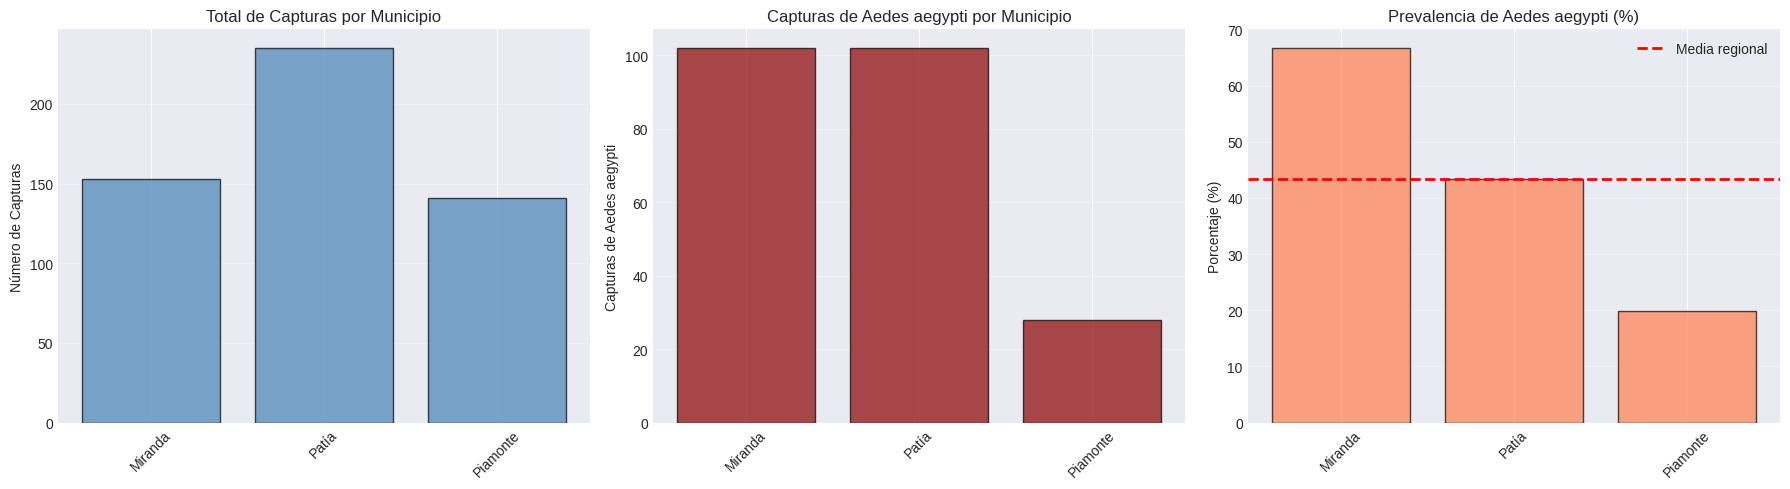

In [ ]:
# ============================================================================
# 8. DISTRIBUCIÓN ESPACIAL DE VECTORES
# ============================================================================

print(f"\n{'='*80}")
print("DISTRIBUCIÓN ESPACIAL DE VECTORES")
print(f"{'='*80}")

# Capturas por municipio
capturas_municipio = df_vectores.groupby('county').agg({
    'id': 'count',
    'individualCount': 'sum'
}).reset_index()
capturas_municipio.columns = ['Municipio', 'Num_Capturas', 'Total_Individuos']
capturas_municipio['Pct_Capturas'] = (capturas_municipio['Num_Capturas'] /
                                       capturas_municipio['Num_Capturas'].sum() * 100).round(1)

# Aedes aegypti por municipio
aedes_municipio = aedes_aegypti.groupby('county').agg({
    'id': 'count',
    'individualCount': 'sum'
}).reset_index()
aedes_municipio.columns = ['Municipio', 'Capturas_Aedes', 'Individuos_Aedes']

# Merge
distribucion = pd.merge(capturas_municipio, aedes_municipio, on='Municipio', how='left')
distribucion['Pct_Aedes'] = (distribucion['Capturas_Aedes'] /
                              distribucion['Num_Capturas'] * 100).round(1)

print("\nTabla 4.7: Distribución de Capturas por Municipio")
print(distribucion.to_string(index=False))

# Visualización espacial
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Total capturas
axes[0].bar(distribucion['Municipio'], distribucion['Num_Capturas'],
           color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Número de Capturas')
axes[0].set_title('Total de Capturas por Municipio')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. Aedes aegypti por municipio
axes[1].bar(distribucion['Municipio'], distribucion['Capturas_Aedes'],
           color='darkred', edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Capturas de Aedes aegypti')
axes[1].set_title('Capturas de Aedes aegypti por Municipio')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# 3. Porcentaje Aedes aegypti
axes[2].bar(distribucion['Municipio'], distribucion['Pct_Aedes'],
           color='coral', edgecolor='black', alpha=0.7)
axes[2].set_ylabel('Porcentaje (%)')
axes[2].set_title('Prevalencia de Aedes aegypti (%)')
axes[2].axhline(y=distribucion['Pct_Aedes'].mean(), color='red',
               linestyle='--', label='Media regional', linewidth=2)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('fig_4_11_distribucion_espacial.png', dpi=300, bbox_inches='tight')
plt.show()



ANÁLISIS DE MICROHÁBITATS

Distribución por Tipo de Hábitat:
          habitat  capturas  porcentaje
Intradomiciliario       529       100.0

Distribución de Aedes aegypti por Hábitat:
          habitat  capturas  porcentaje
Intradomiciliario       232       100.0

🏠 Preferencia doméstica Aedes aegypti: 100.0% (intra + peridomiciliario)


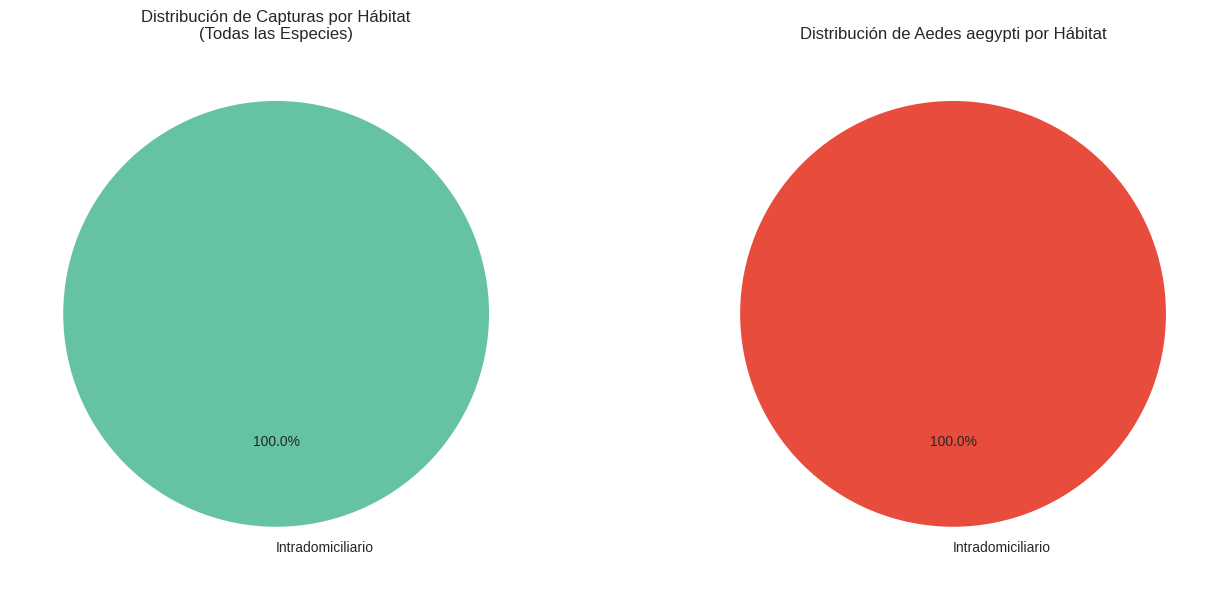

In [ ]:
# ============================================================================
# 9. ANÁLISIS DE MICROHÁBITATS
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE MICROHÁBITATS")
print(f"{'='*80}")

# Extraer información de localidad para clasificar hábitat
def clasificar_habitat(locality_str):
    """Clasificar hábitat basado en descripción de localidad"""
    if pd.isna(locality_str):
        return 'Desconocido'

    locality_str = str(locality_str).lower()

    if 'casa' in locality_str or 'vivienda' in locality_str or 'habitación' in locality_str:
        return 'Intradomiciliario'
    elif 'patio' in locality_str or 'jardin' in locality_str or 'peri' in locality_str:
        return 'Peridomiciliario'
    elif 'campo' in locality_str or 'cultivo' in locality_str or 'extra' in locality_str:
        return 'Extradomiciliario'
    else:
        return 'Otro'

df_vectores['habitat'] = df_vectores['locality'].apply(clasificar_habitat)

habitat_dist = df_vectores.groupby('habitat').size().reset_index(name='capturas')
habitat_dist['porcentaje'] = (habitat_dist['capturas'] / habitat_dist['capturas'].sum() * 100).round(1)

print("\nDistribución por Tipo de Hábitat:")
print(habitat_dist.to_string(index=False))

# Hábitat específico para Aedes aegypti
aedes_habitat = aedes_aegypti.copy()
aedes_habitat['habitat'] = aedes_habitat['locality'].apply(clasificar_habitat)
aedes_habitat_dist = aedes_habitat.groupby('habitat').size().reset_index(name='capturas')
aedes_habitat_dist['porcentaje'] = (aedes_habitat_dist['capturas'] /
                                     aedes_habitat_dist['capturas'].sum() * 100).round(1)

print("\nDistribución de Aedes aegypti por Hábitat:")
print(aedes_habitat_dist.to_string(index=False))

pct_domiciliario = aedes_habitat_dist[aedes_habitat_dist['habitat'].str.contains('domiciliario',
                                       case=False, na=False)]['porcentaje'].sum()
print(f"\n🏠 Preferencia doméstica Aedes aegypti: {pct_domiciliario:.1f}% (intra + peridomiciliario)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Todas las especies
axes[0].pie(habitat_dist['capturas'], labels=habitat_dist['habitat'],
           autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribución de Capturas por Hábitat\n(Todas las Especies)')

# Gráfico 2: Solo Aedes aegypti
axes[1].pie(aedes_habitat_dist['capturas'], labels=aedes_habitat_dist['habitat'],
           autopct='%1.1f%%', startangle=90, colors=['#e74c3c', '#f39c12', '#95a5a6'])
axes[1].set_title('Distribución de Aedes aegypti por Hábitat')

plt.tight_layout()
plt.savefig('fig_4_12_microhabitats.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ============================================================================
# 10. MAPA INTERACTIVO DE VECTORES
# ============================================================================

print(f"\n{'='*80}")
print("GENERANDO MAPA INTERACTIVO DE VECTORES")
print(f"{'='*80}")

# Centro del mapa
centro_lat = df_vectores['decimalLatitude'].mean()
centro_lon = df_vectores['decimalLongitude'].mean()

# Crear mapa
mapa_vectores = folium.Map(
    location=[centro_lat, centro_lon],
    zoom_start=9,
    tiles='OpenStreetMap'
)

# Agregar marcadores para Aedes aegypti
for idx, row in aedes_aegypti.iterrows():
    # Color según abundancia
    if row['individualCount'] >= 10:
        color = 'red'
        icon = 'exclamation-triangle'
    elif row['individualCount'] >= 5:
        color = 'orange'
        icon = 'warning'
    else:
        color = 'green'
        icon = 'info-sign'

    folium.CircleMarker(
        location=[row['decimalLatitude'], row['decimalLongitude']],
        radius=min(row['individualCount'], 15),
        popup=f"Aedes aegypti<br>Individuos: {row['individualCount']}<br>Fecha: {row['eventDate'].date()}<br>Municipio: {row['county']}",
        tooltip=f"{row['individualCount']} individuos",
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.6
    ).add_to(mapa_vectores)

# Guardar
mapa_vectores.save('mapa_interactivo_vectores.html')
print("✓ Mapa interactivo guardado: mapa_interactivo_vectores.html")


GENERANDO MAPA INTERACTIVO DE VECTORES
✓ Mapa interactivo guardado: mapa_interactivo_vectores.html


In [ ]:
# ============================================================================
# 11. CALIDAD DE DATOS ENTOMOLÓGICOS
# ============================================================================

print(f"\n{'='*80}")
print("EVALUACIÓN DE CALIDAD DE DATOS ENTOMOLÓGICOS")
print(f"{'='*80}")

calidad = []

for col in ['eventDate', 'decimalLatitude', 'decimalLongitude', 'scientificName',
            'individualCount', 'sex']:
    total = len(df_vectores)
    no_nulos = df_vectores[col].notna().sum()
    completitud = (no_nulos / total * 100)

    # Validez específica por columna
    if col in ['decimalLatitude', 'decimalLongitude']:
        if col == 'decimalLatitude':
            validos = ((df_vectores[col] >= 0.5) & (df_vectores[col] <= 4.0)).sum()
        else:
            validos = ((df_vectores[col] >= -78.0) & (df_vectores[col] <= -75.0)).sum()
    elif col == 'individualCount':
        validos = (df_vectores[col] > 0).sum()
    else:
        validos = no_nulos

    validez = (validos / no_nulos * 100) if no_nulos > 0 else 0

    calidad.append({
        'Variable': col,
        'Completitud (%)': f"{completitud:.1f}",
        'Validez (%)': f"{validez:.1f}",
        'Observaciones': '✓ OK' if completitud >= 99 and validez >= 99 else '⚠ Revisar'
    })

calidad_df = pd.DataFrame(calidad)
print("\nTabla 4.8: Evaluación de Calidad de Datos Entomológicos")
print(calidad_df.to_string(index=False))


EVALUACIÓN DE CALIDAD DE DATOS ENTOMOLÓGICOS

Tabla 4.8: Evaluación de Calidad de Datos Entomológicos
        Variable Completitud (%) Validez (%) Observaciones
       eventDate           100.0       100.0          ✓ OK
 decimalLatitude           100.0       100.0          ✓ OK
decimalLongitude           100.0       100.0          ✓ OK
  scientificName           100.0       100.0          ✓ OK
 individualCount           100.0       100.0          ✓ OK
             sex           100.0       100.0          ✓ OK


In [ ]:
# ============================================================================
# 12. RESUMEN EJECUTIVO
# ============================================================================

print(f"\n{'='*80}")
print("RESUMEN EJECUTIVO - HALLAZGOS ENTOMOLÓGICOS")
print(f"{'='*80}\n")

print("📊 DATOS GENERALES:")
print(f"   • Total capturas: {len(df_vectores)}")
print(f"   • Total individuos: {df_vectores['individualCount'].sum():,}")
print(f"   • Período: {df_vectores['eventDate'].min().date()} a {df_vectores['eventDate'].max().date()}")
print(f"   • Especies identificadas: {df_vectores['scientificName'].nunique()}")

print(f"\n🦟 AEDES AEGYPTI (Vector principal):")
print(f"   • Prevalencia en capturas: {len(aedes_aegypti)/len(df_vectores)*100:.1f}%")
print(f"   • Prevalencia en individuos: {aedes_aegypti['individualCount'].sum()/df_vectores['individualCount'].sum()*100:.1f}%")
print(f"   • Ratio Hembra:Macho: {total_hembras/total_machos:.2f}:1")
print(f"   • Preferencia doméstica: {pct_domiciliario:.1f}%")

print(f"\n📈 PATRONES TEMPORALES:")
print(f"   • Mes de mayor abundancia: {mes_pico}")
print(f"   • Duración vigilancia: {(df_vectores['eventDate'].max() - df_vectores['eventDate'].min()).days} días")

print(f"\n🗺️  DISTRIBUCIÓN ESPACIAL:")
print(f"   • Municipio con más capturas: {distribucion.loc[distribucion['Num_Capturas'].idxmax(), 'Municipio']}")
print(f"   • Mayor prevalencia Aedes: {distribucion['Pct_Aedes'].max():.1f}% ({distribucion.loc[distribucion['Pct_Aedes'].idxmax(), 'Municipio']})")

print(f"\n✅ PREPARACIÓN PARA MODELADO:")
print(f"   • Datos limpios: SÍ")
print(f"   • Coordenadas validadas: SÍ")
print(f"   • Clasificación taxonómica: SÍ")
print(f"   • Variables temporales: SÍ")

print(f"\n{'='*80}")
print("ANÁLISIS ENTOMOLÓGICO COMPLETADO")
print(f"{'='*80}")
print("\n✓ Visualizaciones guardadas")
print("✓ Mapa interactivo: mapa_interactivo_vectores.html")
print("✓ Dataset listo para integración (Fase 2)")

# Exportar dataset procesado
df_vectores.to_csv('vectors_processed.csv', index=False)
print(f"\n✓ Dataset procesado guardado: vectors_processed.csv ({len(df_vectores)} filas)")

print("\n" + "="*80)
print("FIN DEL NOTEBOOK 02")
print("="*80)


RESUMEN EJECUTIVO - HALLAZGOS ENTOMOLÓGICOS

📊 DATOS GENERALES:
   • Total capturas: 529
   • Total individuos: 2,383
   • Período: 2021-02-10 a 2021-11-11
   • Especies identificadas: 3

🦟 AEDES AEGYPTI (Vector principal):
   • Prevalencia en capturas: 43.9%
   • Prevalencia en individuos: 24.0%
   • Ratio Hembra:Macho: 22.56:1
   • Preferencia doméstica: 100.0%

📈 PATRONES TEMPORALES:
   • Mes de mayor abundancia: November
   • Duración vigilancia: 274 días

🗺️  DISTRIBUCIÓN ESPACIAL:
   • Municipio con más capturas: Patía
   • Mayor prevalencia Aedes: 66.7% (Miranda)

✅ PREPARACIÓN PARA MODELADO:
   • Datos limpios: SÍ
   • Coordenadas validadas: SÍ
   • Clasificación taxonómica: SÍ
   • Variables temporales: SÍ

ANÁLISIS ENTOMOLÓGICO COMPLETADO

✓ Visualizaciones guardadas
✓ Mapa interactivo: mapa_interactivo_vectores.html
✓ Dataset listo para integración (Fase 2)

✓ Dataset procesado guardado: vectors_processed.csv (529 filas)

FIN DEL NOTEBOOK 02
